<a href="https://colab.research.google.com/github/mukdame/Trading/blob/master/aapl_regression_scikit_learn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building a Regression Model for a Financial Dataset

In this notebook, you will build a simple linear regression model to predict the closing AAPL stock price. The lab objectives are:
* Pull data from BigQuery into a Pandas dataframe
* Use Matplotlib to visualize data
* Use Scikit-Learn to build a regression model

In [0]:
# #Download training data here!
# git clone https://github.com/GoogleCloudPlatform/training-data-analyst 

In [0]:
# %%bash

# bq mk -d ai4f

# bq load --autodetect --source_format=CSV ai4f.AAPL10Y gs://
# cloud-training/ai4f/AAPL10Y.csv

In [0]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

plt.rc('figure', figsize=(12, 8.0))

## Pull Data from BigQuery

In this section we'll use a magic function to query a BigQuery table and then store the output in a Pandas dataframe. A magic function is just an alias to perform a system command. To see documentation on the "bigquery" magic function execute the following cell:

In [0]:
# %%bigquery?

The query below selects everything you'll need to build a regression model to predict the closing price of AAPL stock. The model will be very simple for the purposes of demonstrating BQML functionality. The only features you'll use as input into the model are the previous day's closing price and a three day trend value. The trend value can only take on two values, either -1 or +1. If the AAPL stock price has increased over any two of the previous three days then the trend will be +1. Otherwise, the trend value will be -1.

Note, the features you'll need can be generated from the raw table `ai4f.AAPL10Y` using Pandas functions. However, it's better to take advantage of the serverless-ness of BigQuery to do the data pre-processing rather than applying the necessary transformations locally.  

In [0]:
# %%bigquery df
# WITH
#   raw AS (
#   SELECT
#     date,
#     close,
#     LAG(close, 1) OVER(ORDER BY date) AS min_1_close,
#     LAG(close, 2) OVER(ORDER BY date) AS min_2_close,
#     LAG(close, 3) OVER(ORDER BY date) AS min_3_close,
#     LAG(close, 4) OVER(ORDER BY date) AS min_4_close
#   FROM
#     `ai4f.AAPL10Y`
#   ORDER BY
#     date DESC ),
#   raw_plus_trend AS (
#   SELECT
#     date,
#     close,
#     min_1_close,
#     IF (min_1_close - min_2_close > 0, 1, -1) AS min_1_trend,
#     IF (min_2_close - min_3_close > 0, 1, -1) AS min_2_trend,
#     IF (min_3_close - min_4_close > 0, 1, -1) AS min_3_trend
#   FROM
#     raw ),
#   train_data AS (
#   SELECT
#     date,
#     close,
#     min_1_close AS day_prev_close,
#     IF (min_1_trend + min_2_trend + min_3_trend > 0, 1, -1) AS trend_3_day
#   FROM
#     raw_plus_trend
#   ORDER BY
#     date ASC )
# SELECT
#   *
# FROM
#   train_data

View the first five rows of the query's output. Note that the object `df` containing the query output is a Pandas Dataframe.

In [0]:
# print(type(df))
# df.dropna(inplace=True)
# df.head()

In [0]:
# print(df)
# import os
# cwd = os.getcwd()
# print(cwd)
# export_csv = df.to_csv (r'/home/jupyter/training-data-analyst/courses/ai-for-finance/practice/AAPL_Stock.csv', index = None, header=True)

            date     close  day_prev_close  trend_3_day
1     2009-06-04   20.5343         20.1357           -1
2     2009-06-05   20.6671         20.5343           -1
3     2009-06-08   20.5500         20.6671            1
4     2009-06-09   20.3886         20.5500            1
5     2009-06-10   20.0357         20.3886           -1
...          ...       ...             ...          ...
2512  2019-05-28  178.2300        178.9700           -1
2513  2019-05-29  177.3800        178.2300           -1
2514  2019-05-30  178.3000        177.3800           -1
2515  2019-05-31  175.0700        178.3000           -1
2516  2019-06-03  173.3000        175.0700           -1

[2516 rows x 4 columns]
/home/jupyter/training-data-analyst/courses/ai-for-finance/practice


In [0]:
url = 'https://raw.githubusercontent.com/mukdame/Trading/master/AAPL_Stock.csv'
df = pd.read_csv(url)

## Visualize data

The simplest plot you can make is to show the closing stock price as a time series. Pandas DataFrames have built in plotting funtionality based on Matplotlib. 

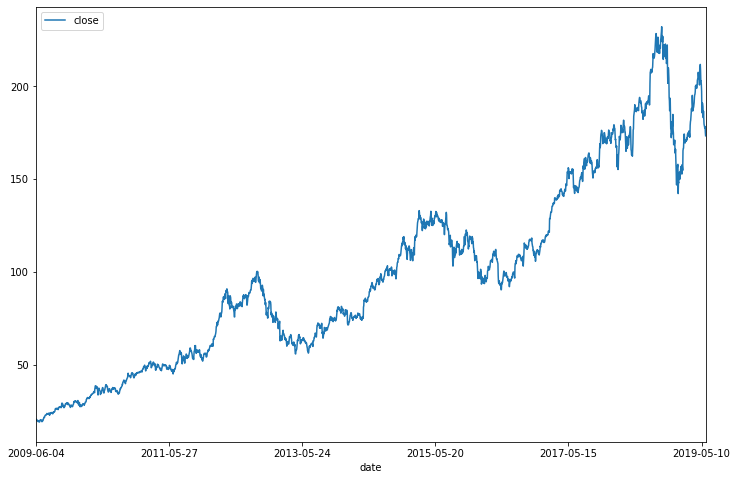

In [0]:
df.plot(x='date', y='close');

You can also embed the `trend_3_day` variable into the time series above. 

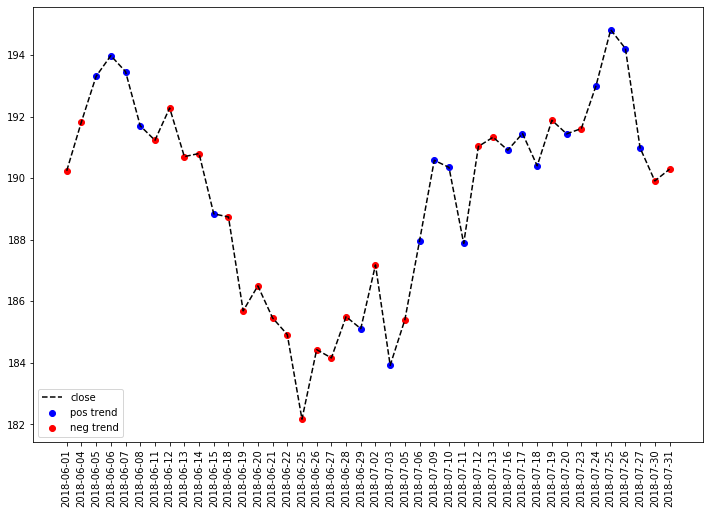

In [0]:
start_date = '2018-06-01'
end_date = '2018-07-31'

plt.plot(
    'date', 'close', 'k--',
    data = (
        df.loc[pd.to_datetime(df.date).between(start_date, end_date)]
    )
)

plt.scatter(
    'date', 'close', color='b', label='pos trend', 
    data = (
        df.loc[df.trend_3_day == 1 & pd.to_datetime(df.date).between(start_date, end_date)]
    )
)

plt.scatter(
    'date', 'close', color='r', label='neg trend',
    data = (
        df.loc[(df.trend_3_day == -1) & pd.to_datetime(df.date).between(start_date, end_date)]
    )
)

plt.legend()
plt.xticks(rotation = 90);

In [0]:
df.shape

(2516, 4)

## Build a Regression Model in Scikit-Learn

In this section you'll train a linear regression model to predict AAPL closing prices when given the previous day's closing price `day_prev_close` and the three day trend `trend_3_day`. A training set and test set are created by sequentially splitting the data after 2000 rows. 

In [0]:
features = ['day_prev_close', 'trend_3_day']
target = 'close'

X_train, X_test = df.loc[:2000, features], df.loc[2000:, features]
y_train, y_test = df.loc[:2000, target], df.loc[2000:, target]

In [0]:
# Create linear regression object. Don't include an intercept,
# TODO
# See this example https://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html#sphx-glr-auto-examples-linear-model-plot-ols-py
from sklearn.linear_model import LinearRegression
regr = LinearRegression()

In [0]:
# Train the model using the training set
# TODO
regr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
# Make predictions using the testing set
# TODO
y_pred = regr.predict(X_test)
ind = range(2000,2516)
y_pred = pd.Series(y_pred, index=ind)

In [0]:
# Print the root mean squared error of your predictions
# TODO
# RMSE squared set to False
from sklearn.metrics import mean_squared_error, r2_score
print('Root Mean squared error: %.2f' % np.sqrt(mean_squared_error(y_test, y_pred)))

Root Mean squared error: 2.98


In [0]:
# Print the variance score (1 is perfect prediction)
# TODO

# The coefficients
print('Coefficients: \n', regr.coef_)
print('Coefficient of determination: %.2f' % r2_score(y_test, y_pred))

Coefficients: 
 [0.99986364 0.0285962 ]
Coefficient of determination: 0.98


In [0]:
print(type(y_train))
print(type(y_test))
print(type(y_pred))
print(y_test[2000])
print(y_train, y_test, y_pred)

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
155.7
0        20.5343
1        20.6671
2        20.5500
3        20.3886
4        20.0357
          ...   
1996    153.9900
1997    153.2600
1998    153.9500
1999    156.1000
2000    155.7000
Name: close, Length: 2001, dtype: float64 2000    155.70
2001    155.47
2002    150.25
2003    152.54
2004    153.06
         ...  
2511    178.23
2512    177.38
2513    178.30
2514    175.07
2515    173.30
Name: close, Length: 516, dtype: float64 2000    156.183903
2001    155.783958
2002    155.496797
2003    150.277509
2004    152.567196
           ...    
2511    178.993593
2512    178.253693
2513    177.403809
2514    178.323684
2515    175.094124
Length: 516, dtype: float64


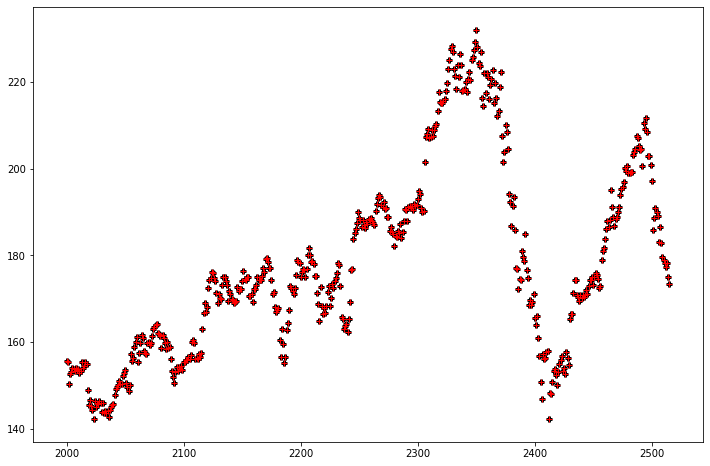

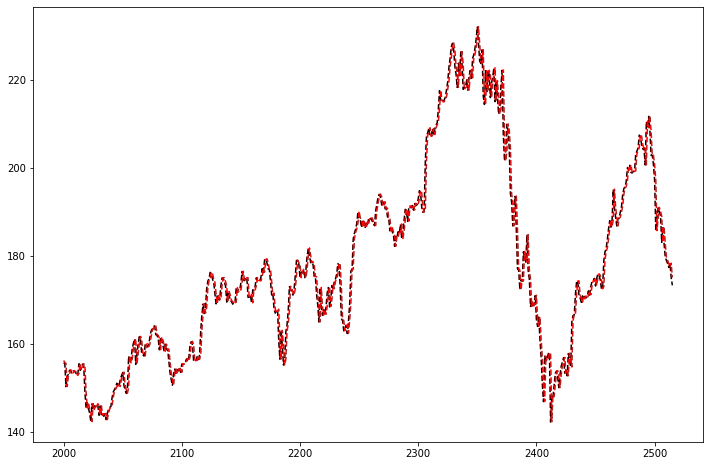

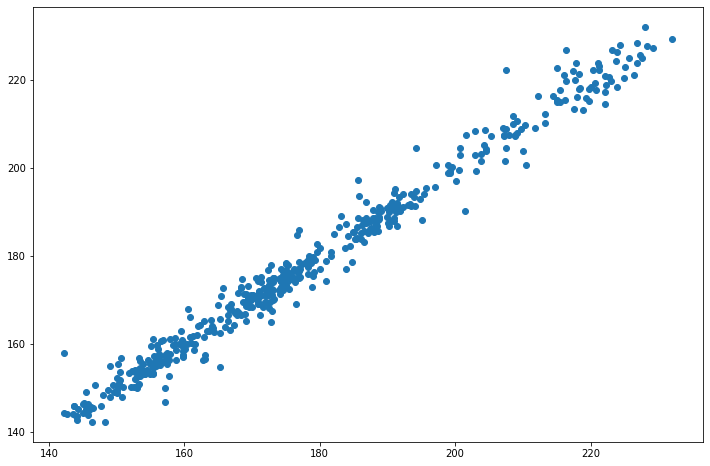

In [0]:
# Plot the predicted values against their corresponding true values
# TODO
import matplotlib.pyplot as plt

plt.scatter(y_test.index, y_test.values, color='black', marker='+', linewidth=3)
plt.scatter(y_pred.index, y_test.values, color='red', marker="+", linewidth=1)
plt.show()

plt.plot(y_test.index, y_test.values, 'k--')
plt.plot(y_pred.index, y_pred.values, 'r--')
plt.show()

plt.scatter(y_test, y_pred)
plt.show()

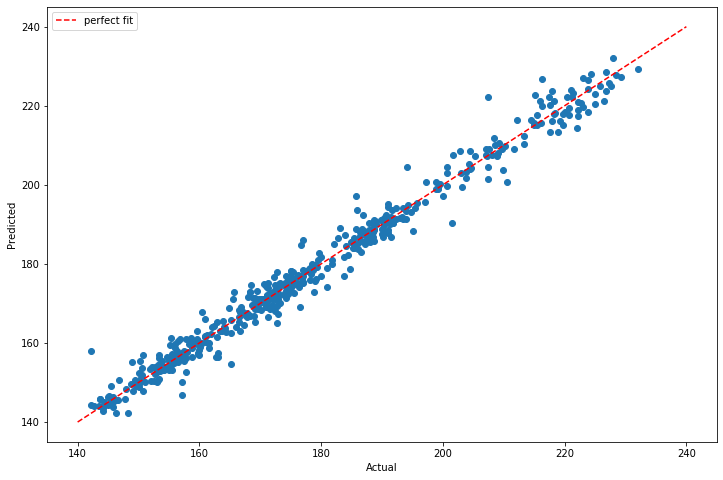

In [0]:
plt.scatter(y_test, y_pred)
plt.plot([140, 240], [140, 240], 'r--', label='perfect fit')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend();

The model's predictions are more or less in line with the truth. However, the utility of the model depends on the business context (i.e. you won't be making any money with this model). It's fair to question whether the variable `trend_3_day` even adds to the performance of the model:

In [0]:
print('Root Mean Squared Error: {0:.2f}'.format(np.sqrt(mean_squared_error(y_test, X_test.day_prev_close))))

Root Mean Squared Error: 2.98


Indeed, the RMSE is actually lower if we simply use the previous day's closing value as a prediction! Does increasing the number of days included in the trend improve the model? Feel free to create new features and attempt to improve model performance!